In [1]:
import os 
import sys
sys.path.append('../dependencies/')

import shutil
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import flopy

# import specific FloPy modules
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect

# for working with shapefiles
import shapefile as sf
from shapely.geometry import Polygon, LineString, MultiLineString

print(f'Flopy version:{flopy.__version__}')

Flopy version:3.8.2


# Introduction
In this notebook we will construct the SGN model. This is a model of a geothermal instalation in Milan. It is the same case-study site which is addressed in the PEST/PEST++ part of this course. However, the model used in the PEST/PEST++ class will be slightly diferent as it is constructed in Groundwater Vistas. The purpose of the current class is to demonstrate how to use Flopy using a real-world case and input files. 

## General Outline
- For the current exercise, we will construct a model using MODFLOW6. This model will use a DISV grid type. This allows us to add zones of greater grid resolution, whilst retaining a layered approach. We will use the USGS software GRIDGEN to construct the model grid. GRIDGEN executables are in the "bin" folder. 
- Next we will create the MF6 simulation object, along with the time discretisation.
- Then we will create the MF6 model object, based on the DISV grid created using GRIDGEN.
- Then we will assign model properties and boundary conditions.
- Next we will write the model files. At this stage you can inspect the MF6 input files if you wish (not a bad practice...)
- Then we can run the model.
- Then we can inspect the results.

# Getting started
## Workspace and often accessed folders
The "workspace" is the folder in which the model files will be written. Flopy needs to be informed where to read/write model files from.


Depending on how input files and data are orgnaised, it may also be convenient to define the folder in which data files are stored (assuming we will be loading in lots of files from that folder throughout the model construction process). This is not a requirement, merely personal preference. For the current case, all input data files are housed in the folder "..\data\sgn".

We will be using a few executables (*.exe) files trought this exercise. Usualy they should be in your PATH. Alterantively, you will need to specify the full path to the exectuable when it is called. They are housed in the "bin" folder.

In [2]:
# define the location of the model working directory; this is where all the MF6 files will be written
# the folder path is relative to the location in which python is running. In our case, relative to the location of the jupyter notebok file.
workspace = os.path.join('..','models','sgn_model_1layer')

# Create the folder and make sure it is clean/empty.
if os.path.exists(workspace):
    shutil.rmtree(workspace)

# the relative pathto the input file folder
datadir = os.path.join('..','data','sgn')

# the relative path to the executables folder
bindir = os.path.join('..','bin')

After you ran the previous cell, you will find a new directory in the repository folder "models" named "sgn_model". It will be empty, but this is where your model files will be going. It is usefull to chekc these files, specialy if a model is giving you trouble. When using GUI's (or flopy) users often lose touch with what is actualy going on with MODFLOW in the background. Get to know MODFLOW file structures. Trust me, you'll appreciate it in the long run.


# Construct the grid
## GRIDGEN
GRIDGEN allows you to create layered quad-tree refined model grids. It is possible to set up and run GRIDGEN using FlopY, allowing for easy grid construction and import.

There are other ways to create unstructructured grids which FLopy can then use to build a model grid. TRIANGLE can be used to generate triangular or voronoi grids (there is a FloPy module to drive TRIANGLE as well). You can also write your own program to build grid inputs. Or you can use external software such as Algomesh or Processing Modflow to construct the grids and then import them. However, that kind of defeats the purpose of scripted model develpment. 

The FloPy git-hub repository has example notebooks on how to use the GRIDGEN and TRIANGLE modules.

In [3]:
# define the fullpath to the gridgen exe 
gridgen_exe = 'gridgen.exe' #os.path.join(bindir, 'gridgen.exe')

# gridgen will write a bunch of files; lets keep them seperate from the MF6 files, but within the same model workspace folder. To do so create a gridgen workspace sub-folder
gridgen_ws = os.path.join(workspace, 'gridgen')
if not os.path.exists(gridgen_ws):
    os.makedirs(gridgen_ws)

GRIDGEN works off of a base structured MODFLOW grid. So first we need to define a "base grid". This is the smae as createing an old-school rectangular grid which covers the extent of the model we are going to construct. Think of it as a rectangle which covers the model extent. 

The "box" around the model area of interest which we wish to model is roughly 4500m by 5000 m. In the coordinate system in which all the input files are recorded, the coordinate of the upper left corner is aproximately x=1516500, y=5033650. The main direction of flow is roughly 14.1 deg.

Let's create a grid with these conditions.

In [4]:
#Creating the initial Grid
# grid dimmensions
Lx = 4150.
Ly = 4810.
xul, yul = 1516769.1487, 5033577.7911 # the upper left corner of the bounding box
rot = 14

# create a uniform cell size 50 x 50
delr = delc = 50 
# calculate the number of rows and columns
nrow = int(Ly / delc)
ncol = int(Lx / delr)

# set some dummy values for top and bottom. We will get values for the model from raster files later on.
top = 1
botm=0

# we can then use the FloPy Modflow module to create a DIS object
ms = flopy.modflow.Modflow(rotation=rot)
dis = flopy.modflow.ModflowDis(ms, nlay=1, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=top, botm=botm, xul=xul, yul=yul)

# lets plot the bottom of the grid, just so we can see it makes sense
#dis.botm.plot(colorbar=True, grid=True);

In [5]:
# Now we can instantiate a gridgen objct using the dis we just created.
g = Gridgen(dis, model_ws=gridgen_ws, exe_name=gridgen_exe)

C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\envs\gmdsitut\Lib\site-packages\flopy\utils\gridgen.py:233: UserWarning: Supplying a dis object is deprecated, and support will be removed in version 3.3.7. Please supply StructuredGrid.
  warnings.warn(


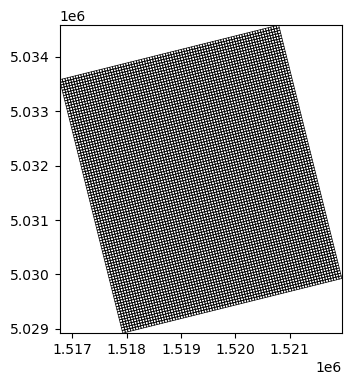

In [9]:
# lets quickly build that and see what it looks like
# build the grid
g.build(verbose=False)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5);

Thats great, but we wanted to add some refinment to certain areas. 

We wish to increase the refinement in a two zones of the model domain around an area of greater interest. These zones are outlined by a shapefile that we have in the "data" folder.

We will start by loading the shapefile and then passing it to GRIDGEN to add refinment. For this we will use the "shapefile" library which we imported as "sf".


In [ ]:
# the path to the shapefile
refine_shpfile = os.path.join(datadir, 'shp', 'Quadtree_level.shp')

# use the sf.Reader function to load the shape as a sf Shapefile object
refine_shp = sf.Reader(refine_shpfile).shapes()

# see how many features are in the shape file
print(f"There are {len(refine_shp)} shapes in the shapefile.")

In [ ]:
# We want to add diferent levels of refinement to each of those features
# the input formats are a bit weird..I am sure there is a reason for it, but oh well
# the add_refinment_features requires a list of list of tuples. The tuples contian the (x,y) coordinates of the refinment shape. 
refinment_level = 1
for i in refine_shp:
    g.add_refinement_features([i], 'polygon', refinment_level, [0])
    #add +1 to the refinemnt level for the second polygon
    refinment_level+=1

# lets quickly build that and see what it looks like
# build the grid
g.build(verbose=False)

# Visualize the grid
#fig = plt.figure(figsize=(4, 4))
#ax = fig.add_subplot(1, 1, 1, aspect='equal')
#g.plot(ax, linewidth=0.5);

In [ ]:
# Let us also add refinement along the river
# the path to the shapefile
riv_shpfile = os.path.join(datadir, 'shp', 'River_Lambro.shp')
# use the sf.Reader function to load the shape as a sf Shapefile object
riv_shp = sf.Reader(riv_shpfile).shapes()
# see how many features are in the shape file
print(f"There are {len(riv_shp)} shapes in the shapefile.")

# add refinement, this time define as line not polygon
g.add_refinement_features([[riv_shp[0].points]], 'line', 1, [0])

# lets quickly build that and see what it looks like
# build the grid
g.build(verbose=False)

# Visualize the grid
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5);

# lets also plot the shape file polygon that contains the desired model boundary, for comparison
flopy.plot.plot_shapefile(sf.Reader(os.path.join(datadir, 'shp', 'Model_domain.shp')), ax=ax, linewidth=1, alpha=0.5);

In [ ]:
# finaly, lets set the active domain
# add the active domain
boundary = sf.Reader(os.path.join(datadir, 'shp', 'Model_domain.shp')).shapes()
g.add_active_domain([boundary[0]], [0])

# lets quickly build that and see what it looks like
# build the grid
g.build(verbose=False)

# Visualize the grid
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5);
flopy.plot.plot_shapefile(sf.Reader(os.path.join(datadir, 'shp', 'Model_domain.shp')), ax=ax, linewidth=1, alpha=0.5);

Now that we have created created a GRidGEN grid object, we can use inbuilt functions to obtain grid properties to construct the MODFLOW6 grid object.

In [ ]:
# get the grid properties and store them in rec array
gridprops = g.get_gridprops_disv()
# get the number of cell per layer
ncpl = gridprops['ncpl']
# get the number of vertices
nvert = gridprops['nvert']
#get the vertices and their coordinates
vertices = gridprops['vertices']
# get the cell2d properties
cell2d = gridprops['cell2d']

Each of the lists above are used as input when building a MF6 disv grid. But a few things are still missing:
- number of layers. Our model is to have **ONE** layer.
- the elevation of the top of the model. In the data folder there is a raster file of the DEM.
- the elevation of the bootom of the layer. In the data folder there are raster files for the bottom of layer1.

In [ ]:
# start by defining a variable for the number of layers, call it nlay
nlay = 1

# MODFLOW 6

## The Simulation
FloPy requires that we first create a "simulation" object. This simulation can have multiple models. There are a couple of things that you will generaly have to assign:
- a Simulation package
- a TDIS package
- a MF6 Model, which will generaly require:
    - an IMS (i.e. the solver settings) package
    - a spatial discretisation (DIS, DISV or DISU) package
    - initial condition package
    - hydraulic property package(s)
    - boundary condition pacakge(s)

In [ ]:
# the Flopy simulation object
# if the MF6 executable is in your PATH, you can simply assign the string "mf6". If not, you need to specify the location of the executable as shown here:
exe_name = 'mf6.exe' #os.path.join(bindir, 'mf6.exe')

sim = flopy.mf6.MFSimulation(exe_name=exe_name,
                             version="mf6", 
                             sim_ws=workspace, 
                             continue_=True)  # This is an important setting for working with PEST/PEST++ it ensures the model will continue even if convergece is not achieved. Use with caution.

### The TDIS (time discretisation) object
Time discretisation (i.e. the TDIS package) is defined at the simulation level. Lets instantioante a Tdis object. To do so, we need to define the stress period data.

Stress period data needs to be passed to the Tdis object as a list of tuples. The list needs a tuple for each stress period. Each tuple contains the period length, the number of time steps and the time-sep multiplier:
 \[(perlen, nstp, tsmult)]

We will have a single steady-state stress-period and not considering transport, so period length does not matter. Number of time steps should be 1, and time-step multiplier does not matter.

In [ ]:
# we will use units of "seconds"; so all time related values must be in seconds
time_units = 'seconds'

#perioddata[perlen, nstp, tsmult]
perioddata = [(1.0, 1, 1.0)] 
# set the number of periods, in this case 1
nper= len(perioddata)


# we can deinfe the sarting date_time; it doesnt matter here, but we will do so for demo purposes:
start_date_time = '2021-06-01' #should be in the format '%Y-%m-%d'

tdis = flopy.mf6.ModflowTdis(sim, pname="tdis",
                                  nper=nper, 
                                  perioddata=perioddata, 
                                  time_units=time_units, 
                                  start_date_time=start_date_time)

## The Flow Model
 Now we can create the FloPy MF6 model object and add the corresponding IMS package to the simulation.

In [ ]:
# Instantiate the Flopy groundwater flow (gwf) model object
model_name = 'sgn'
gwf = flopy.mf6.ModflowGwf(sim,
                            modelname=model_name,
                            save_flows=True, print_flows=True)

# Instantiate a Flopy `IMS` Package object
# Here you can set all the solver settings, all of these have default values so you dont need to specify them if the defaults are suficient.
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

ims = flopy.mf6.ModflowIms(sim,         
                            outer_maximum=nouter,
                            outer_dvclose=hclose,
                            inner_maximum=ninner,
                            inner_dvclose=hclose,
                            rcloserecord="{} strict".format(rclose))

# lastly we need to register the MF6 model to an IMS package in the Simulation
sim.register_ims_package(ims, [gwf.name])

In [ ]:
# Now, you wouldnt necessarily start writting model files yet, but lets do so just to see what happens.
sim.write_simulation()

Inspect the model workspace folder. You will see the files:

\['gridgen', 'mfsim.nam', 'sgn.nam', 'sim.ims', 'sim.tdis']

### The DISV package
Right! So we can get back to assigning our model grid (Remember all that stuff we were doing earlier with GRIDGEN?).

To do so, we create a FlopY DISV object with *flopy.mf6.ModflowGwfdisv()*

In [ ]:
#Creating grid in mf6 with DISV
# For disv input info: ncpl, nvert, vertices, cell2d (center x,y for each cell)
length_units = "METERS"

# create grid object
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl,length_units=length_units,
                               top=top, botm=botm, nvert=nvert, vertices=vertices, cell2d=cell2d,
                               idomain=[1])

# we can plot it as well! 
# Lets check out the layer bottom elevations
#disv.botm.plot()

# we can also plot the top
#disv.top.plot()

### Sampling from a raster file
Next, we need to create an array (or list) of elevations for each cell to sign to the top of the model. We want to obtain these from the DEM raster. To do so, we need to obtain the elevation in the raster that coincides with the cell coordinates. For that, we need to know the cell coordinates.

In [ ]:
# Import the DEM raster
# set the raster file path and name
raster_file = os.path.join(datadir, 'raster', 'DTM_smooth.tif')

# use the FloPy utils Raster object to load the raster file
raster_dem = flopy.utils.Raster.load(raster_file)

# we can even plot the raster while we are at it. Isnt that cool? Always good to check coordinate systems are the same, for example. 
#raster_dem.plot();

In [ ]:
# We can use the modelgrid attribute to pass the cell locations to the the resample_to_grid function.
# There are several interpolation methods available, lets just use "nearest" because it is faster.
# assign the values to a variable named "top". This will become an array of equal length to ncpl (number of cells per layer)
top = raster_dem.resample_to_grid(modelgrid=gwf.modelgrid,
                                  band=raster_dem.bands[0],
                                  method="nearest")
print(f'top shape={top.shape}')
print(f'ncpl={ncpl}')

 Now lets create the data to define the bottom of each layer. This requires an array of shape (nlay, ncpl). In our case nlay = 1.

 Lets start by creating a dummy array with ones.
 

In [ ]:
botm = np.ones((nlay, ncpl))
botm.shape

Now we need to populate that array from the raster files of layer bottoms. I will do it the "slow way" so that it is easy to follow what is going on. It could be done alot more pythonicly.

In [ ]:
# do the same for the two bottom rasters as we did for the DEM
# set the file names
raster_file_bot1 = os.path.join(datadir, 'raster', 'Bott_L1_fix.tif')
# load the rasters
raster_bot1 = flopy.utils.Raster.load(raster_file_bot1)

# sample the rasters to the cell xy's
botm[0] = raster_bot1.resample_to_grid(modelgrid=gwf.modelgrid,band=raster_bot1.bands[0], method="nearest")

#botm

Awesome, we can now update the top and botm data in the model disv package.

In [ ]:
disv.top.set_data(top)

disv.top.plot(colorbar=True)

In [ ]:
disv.botm.set_data(botm)

disv.botm.plot(colorbar=True)

### Zonning
Our conceptal model is that the top aquifer (layer 1) has distinct geological zones. The aquiatrd and and lower aquifer are considered to be uniform geological units. The shape file *Geology_250000_clip.shp* defines the geological units in the upper aquifer.

We will be assiginign diferent parameters to diferent zones. Additionaly, when you get to the PESt pat of this course, parameterisation will require zoning. To make life easier, we will distinguish between zones using different IDOMAIN values for each zone.

Let's start by setting up the zones. Load in the shp file and inspect it.

In [ ]:
# the path to the shapefile
zones_shpfile = os.path.join(datadir, 'shp', 'Geology_250000_clip.shp')

# Visualize the grid
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5);

# lets  plot the shape file 
flopy.plot.plot_shapefile(sf.Reader(zones_shpfile), ax=ax, linewidth=1, alpha=0.5);

As you can see. There are several polygons within the model domain. However there are only suposed to be two zones. Lets inspect the shapefile records (i.e. the "attribute table" if you open it in QGIS or ArcGIS).

Use the sf.Reader *records()* method to inspect the shapefile records.

In [ ]:
zones_records = sf.Reader(zones_shpfile).records()
zones_records

In [ ]:
# as it is a list, you can access the record for each shape by indexing
zones_records[0]

In [ ]:
# and then specific attributes within the shape record by indexing again
zones_records[0][0]

In [ ]:
# you can also use the sf.Reader.record() function to access specifc records. Note record vs records. The "s" refers to a diferent method.
sf.Reader(zones_shpfile).record(0)

What you see there is a list of lists. Each sub-list contians the recoords assocaited to each polygon (i.e. shape) in the **zones_shpfile**.

As you can see, the information repeats. So there are multiple "shapes", but they all belong to one of two geological units. The numeric code for each unit is given as the first element of the sub-list. In this case, either "301" or "205", which correspon to the "alluvial deposits" and "sands and gravels" respectively. 

To assign zones in the model, we need to know which cells coincide with those zones. To accomplish this for the zones in the top layer we shall use FloPy's GridIntersect module: *flopy.utils.gridintersect.GridIntersect* which we have imported as *GridIntersect*.

In [ ]:
# GridIntersect works by first calling an intersect object on the model grid:
ix = GridIntersect(gwf.modelgrid)

In [ ]:
# Once ix is instantiated, you can now call interscets on the grid using shapely objects
# use the sf.Reader function to load a list of sf Shapefile objects
zones_shp = sf.Reader(zones_shpfile).shapes()

# As there are multiple shapes in the zones_shpfile, zones_shp is a list of shapely objects.
# GridIntersect needs to be applied to each shape in that list of shapes.
# For example, applying to the first shape in the list returns:
x = ix.intersect(zones_shp[0])

# x is a numpy rec.array containting a bunch of information on the intersection between the shape and the model grid.
# it can be easier to visualize as a Pandas dataframe as shown below
# x contains the cellids of model cells intersected by the first shape in zones_shp, as well as the vertices and area of the interesected(!) part of the cell
pd.DataFrame(x).head()

In [ ]:
# you can access cellids or areas directly through the rec.array attributes, by using x.areas or x.cellids
x.cellids

In [ ]:
# So now, we can loop through all the shapes and idntify cellids which belong to each zone
# we will assign corresponding zone numbers to the Idomain array so that we can reuse them in future
# You can acces the idomain values for each layer from the disv object like thus: disv.idomain.data
disv.idomain.data

In [ ]:
# alluviums will be assigned to zone 4, gravels to zone 1
# as we assigned values of 1 to idomain be default, we only need to update cells that interesect alluviaums (i.e. zone 4)
# Note that this will include ANY cell intersected by the polygon shape. So it can include cells that only have a small portion of thier area included in the geological zone. In practice you may wish to consider more elabraote selection criteria (i.e. minimum % of cell area or something like that).
a = disv.idomain.data[0]

for i in range(len(zones_shp)):
    shp = zones_shp[i]
    geo_code = zones_records[i][0]
    if geo_code == 301:
        x = ix.intersect(shp).cellids.astype(int)
        a[x] = 4

# update the disv idomain values using the .set_data() method
disv.idomain.set_data(a, layer=0)

# now lets chck the disv idomain values in layer 1


# Visualize the grid
fig = plt.figure(figsize=(5, 5))
# plot idomain for top layer
disv.idomain.plot(colorbar=True, mflay=0)
# plot the shape file 
flopy.plot.plot_shapefile(sf.Reader(zones_shpfile), linewidth=2, facecolor='grey', edgecolor='w', alpha=0.3);

## Initial conditions
### The intial condition (IC) package

In [ ]:
# set the initial conditions with the IC package
# you can set a single value for the entire model
strt = 50 
# or assign discrete values per layer
strt = [50,10,0]
# or even set the same value for each cell, the same in each layer. For example, equal to tthe array we used to defient he model top. Lets do that:
strt = nlay*[top]

ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=strt)
strt

## Hydraulic conductivity
### per model zone
As we did for strt, k can be assigned per individual cell, layer, or as a single constant value. Recall that we are using units of "meter" and "seconds". So k must be passed as units of "m/s".

From our model brief, we have been given distinct values of for all four zones. Let us assign unique values per zone. Conveniently, we can use the Idomain values to "select" cells from each zone.

zone1 (shallow aquifer; layer 1): 2.3E-3 m/s <br>
zone4 (shallow aquifer; layer 1): 4.1E-3 m/s <br>
zone2 (aquitard): 1E-08 m/s <br>
zone3 (deep aquifer): 2.3E-3 m/s<br>



In [ ]:
# let us start by creating a template for our k input data; we can do so easily enough by making a copy of the idomain. 
k = disv.idomain.data.copy().astype('float')
k

In [ ]:
# now it is a simple to task to slice the k array to assign the values we want
# update the values for each zone
k[k==1] = 2.3E-3 
#k[k==2] = 1E-08
#k[k==3] = 2.3E-3 
k[k==4] = 4.5E-3

# see if that worked
np.unique(k)

All the MODFLOW6 NPF pacakge variables can be assigned to the FloPy *flopy.mf6.ModflowGwfnpf* object. We also want to set the k vertical anisotropy to have a ratio of 0.1 (i.e.  kv = kh/10). This can be assigned using the k33 variable. Vertical hydraulic conductivity can be assinged explicitly (i.e. kv = 1e-3 m/s) or as a ratio. In both cases the k33 variable is used. Defining whether k33 is a ratio is defined with k33overk variable.

In [ ]:
# unique values per layer
npf = flopy.mf6.ModflowGwfnpf(gwf, k=k, 
                              save_flows=True, 
                              save_specific_discharge=None, 
                              k33=0.1, k33overk=True)

# and to see if it worked...
npf.k.plot(colorbar=True)

When working with PEST/PEST++, it is usualy good practice to set packages to write model input data to external files. You will learn more about this in the PEST module of this course. To do, you can simply write *npf.set_all_data_external()*. However, this writes ALL the NPF package files. This can get messy...

Alterantively, you can  specify which files to write using the *npf.k.store_as_external_file()*, for example. Lets do this for the K parameters of all three layers.

To do so, we need to specify the external file and path. You can specify to store values individualy per layer, or all in a single file. Which to choose depends on your case...Let us store the values of K for each layer in a seperate file. Let us name each file with the model name followed by the letter "k" and the layer number (i.e. sgn.k1.txt)

Note that this function will write the package files imediately, not requiring the *sim.write_simulation()* call.

In [ ]:
# write files externaly
for lay in range(nlay):
    external_file_path =  f'{gwf.name}.k{lay+1}.txt' # layer + 1 because FloPy is zero indexed
    npf.k.store_as_external_file(external_file_path=external_file_path,layer=lay)

# Check the model workspace folder.  You will see the three new files written 
for f in os.listdir(workspace):
    if '.k' in f:
        print(f)

Lets write the simulation files again so that we can check what FloPy is doing. Run *sim.write_simultion()* and then inspect the files in your model workspace folder. The *sgn.npf* file has the details of the NPF package, with arrays of K per alyer written in the external files. You can open any of these files in a text editor or even here in your notebook as shown below.

In [ ]:
sim.write_simulation()

In [ ]:
# Check the model workspace folder. 
os.listdir(workspace)

In [ ]:
# read the npf file
with open(os.path.join(workspace, f'{gwf.name}.npf'), 'r') as f:
    a = f.readlines()
a

## Recharge
### Set the recharge over the top layer
We are going to assing a recharge rate to the top layer. We have been provided with a .shp file of recharge polygons which is the file named "Recharge_4.shp" in the data folder.

The shp polygons do not match our grid, so we need to assign spatialy weighted values of interesected shp polygons to each model cell. The shp file contains recharge rates stored as mm/yr in the "records". The model units are m/s. So values also need to be converted to the correct units.

To accomplish this we shall use FloPy's GridIntersect module: *flopy.utils.gridintersect.GridIntersect* which we have imported as *GridIntersect*.

In [ ]:
# the path to the shapefile
rch_shpfile = os.path.join(datadir, 'shp', 'Recharge_4.shp')
# use the sf.Reader function to load the shape as a sf Shapefile object
rch_shp = sf.Reader(rch_shpfile).shapes()

# Visualize the grid
#fig = plt.figure(figsize=(5, 5))
#gwf.modelgrid.plot(linewidth=0.5, alpha=0.5)
# lets  plot the shape file 
#flopy.plot.plot_shapefile(sf.Reader(rch_shpfile),linewidth=1, alpha=0.5);

In [ ]:
# check the records; the recharge rate (mm/yr) is the last element of the record. Zero in hte case shwon below:
sf.Reader(rch_shpfile).record()

In [ ]:
# first we need to get the areas of all cells. As we used GRIDGEN to generate the grid, we COULD access cell areas from the gridgen object using "g.get_area()"
# However, if the grid were generated in another way we would need an alternative method.
g.get_area()

In [ ]:
# lets isntead get the cell areas using GridIntersect as this is a more generalizable case.
# To do so, we create a polygon which extends over the enitre model domain and intersect the grid
# We create the polygon using the shapely.geometry Polygon module that we imported at the beggingin
# get the x and y coordiantes fro the boundaing box; 
xmin, xmax = disv.vertices.array['xv'].min(), disv.vertices.array['xv'].max()
ymin, ymax = disv.vertices.array['yv'].min(), disv.vertices.array['yv'].max()
# make the polygon
bbox = Polygon(shell=[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])  #Polygon(shell=model_vertices_xy, holes=[])

# ineresect all model cells
bbox = ix.intersect(bbox)

# get the areas of all interesected cells
cell_areas = bbox.areas

if ncpl == cell_areas.shape:
    print("I think we got'em all cap'n!")

# note that values are slightly differnt, but not significantly so.
cell_areas

In [ ]:
# Now we have all that we need to start building the RCH package input.
# We can cyclce through each intersect, and fill in the RCH stress period data as we go
# Start by creating the rch spd list which we will populate
spd_rch = []

# for checking purposes
tot_recharge = 0

# for each feature in the shapefile
for i in range(len(rch_shp)):
    shp = rch_shp[i]
    # the shapefile records contain the recharge rate in the last attribute "column"; these values must be converetd from mm/yr to m/s
    rch_rate = sf.Reader(rch_shpfile).record(i)[-1]/1000/365/24/60/60
    # get the intersect
    intersect = ix.intersect(shp)

    for cellix in intersect:
        # get the cell id
        icpl = cellix.cellids
        # get the intersected area
        cellarea = cellix.areas
        # get the total area of the cell
        totarea = cell_areas[icpl]
        # we can use the multipler variable to adjust the recharge rate to the effective area of the cell which is intersected
        mult = cellarea/totarea
    
        # append to the rch spd list
        spd_rch.append(((0, icpl), rch_rate, mult, 'rch'))

        # for checking purposes
        tot_recharge += (rch_rate * cellarea)


# assign the spd data to the RCH package
rch = flopy.mf6.ModflowGwfrch(gwf, filename='{}.rch'.format(model_name), 
                               pname='rch', 
                               auxiliary='MULTIPLIER', auxmultname='MULTIPLIER', boundnames=True,
                               print_input=True, print_flows=True, save_flows=True,
                               stress_period_data=spd_rch, maxbound=84)

# added observation timeseries of recharge so that you can check the mdoel outputs
rch_obs = {('rch.csv'): [('rch', 'RCH', 'rch')]}

rch.obs.initialize(digits=9, print_input=False, 
                   continuous=rch_obs)

# if we parameterize recharge using PEST...
rch.set_all_data_external()

# we will use this value as a check to confirm our model outputs later
print(f'Recharge: {tot_recharge} m3/s')
print(f'Recharge: {tot_recharge * 60*60*24*365} m3/yr')

## River BC
On the east side of the model, the First aquifer could be in communication with the River Lambro, which is inserted in the model as a RIVER condition (Figure 10). The levels of the watercourse were taken from LIDAR quotas and compared with the hydrometer upstream of the model area (Stazione 869 Milano v. Feltre, Figure 11):
 - Hydrometer altitude: average level September 2019: 69.05 cm from hydrometric zero (115.1 m asl) = 115.79 m asl;
 - LIDAR altitude in correspondence with the Hydrometer: 116.2 m asl.


River stages are stored in the shapefile: *River_stages_polyline.shp*

In [ ]:
# the path to the shapefile
riv_shpfile = os.path.join(datadir, 'shp', 'River_stages_polyline.shp')
# use the sf.Reader function to load the shape as a sf Shapefile object
riv_shapes = sf.Reader(riv_shpfile).shapes()


riv_spd=[]
# for each feature in the shapefile
for i in range(len(riv_shapes)):
    shp = riv_shapes[i]
    # the shapefile records contain the stage in the first attribute "column";
    stage = sf.Reader(riv_shpfile).record(i)[0] - 0.4
    # get the intersect
    cellids = ix.intersect(shp).cellids
    cond = 0.001
    rbot = stage - 1.0
    for icpl in cellids:
        riv_spd.append(((0, icpl), stage, cond, rbot, 'riv')) #[cellid, stage, cond, rbot, aux, boundname]


#initilize pacakge
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd, boundnames=True)

# build obs data
riv_obs = { ('riv.csv'):[('riv', 'RIV', 'riv')]}

# initialize obs package
riv.obs.initialize(digits=9, print_input=False,continuous=riv_obs)

riv.set_all_data_external()

In [ ]:
#fig = plt.figure(figsize=(5, 5))
#ax = fig.add_subplot(1, 1, 1, aspect='equal')

# use PlotMapView to plot a DISV  model
#m = flopy.plot.PlotMapView(gwf, layer=0)
#riv = m.plot_bc("RIV")
#linecollection = m.plot_grid(linewidth=0.5, alpha=0.5)

## Set all surfaces cells as DRN to avoid "flooding"

In [ ]:
# set all surface to drain
drnspd = {}
drnspd_i = []
for i in range(ncpl):
    drnu_spd = [(0, i), gwf.dis.top.get_data()[i], 10000, 'surf-drn']
    drnspd_i.append(drnu_spd)

drnspd[0] = drnspd_i

#initilize pacakge
drn = flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=drnspd, boundnames=True)

# build obs data
drn_obs = { ('drn_surf.csv'):[('surf-drn', 'DRN', 'surf-drn')]}

# initialize obs package
drn.obs.initialize(digits=9, print_input=False,continuous=drn_obs)

In [ ]:
#fig = plt.figure(figsize=(5, 5))
#ax = fig.add_subplot(1, 1, 1, aspect='equal')

# use PlotMapView to plot a DISV  model
#m = flopy.plot.PlotMapView(gwf, layer=0)
#riv = m.plot_bc("DRN")
#linecollection = m.plot_grid(linewidth=0.5, alpha=0.5)

# WEll BCs

In [ ]:
# the path to the shapefile
wel_shpfile = os.path.join(datadir, 'shp', 'wells.shp')
# use the sf.Reader function to load the shape as a sf Shapefile object
wel_shapes = sf.Reader(wel_shpfile).shapes()


wel_spd=[]
wel_obs_list=[]

# for each feature in the shapefile
for i in range(len(wel_shapes)):
    shp = wel_shapes[i]
    # the shapefile records contain the stage in the first attribute "column";
    record = sf.Reader(wel_shpfile).record(i)
    pump_rate = record[-1]
    well_id = record[0]
    top_lay = record[3]-1
    bot_lay = record[4]-1

    if top_lay==0:
        wel_obs_list.append((f'well-{well_id}', 'WEL', f'well-{well_id}'))

        # get the intersect
        cellids = ix.intersect(shp).cellids
        for icpl in cellids:
            wel_spd.append(((0, icpl), pump_rate, f'well-{well_id}')) #[cellid, stage, cond, rbot, aux, boundname]


wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd, boundnames=True)

# build obs data 
wel_obs = {('wells.csv'): wel_obs_list}

# initialize obs package
wel.obs.initialize(digits=9, print_input=True, 
                   continuous=wel_obs)



In [ ]:
fig = plt.figure(figsize=(10, 7))
for i in range(nlay):
    ax = fig.add_subplot(1, 3, i+1, aspect='equal')
    ax.set_title(f"WEL in layer{i+1}")
    # use PlotMapView to plot a DISV  model
    m = flopy.plot.PlotMapView(gwf, layer=i)
    riv = m.plot_bc("WEL")
    linecollection = m.plot_grid(linewidth=0.5, alpha=0.5)

fig.tight_layout()

# GHB outer boundary

In order to reproduce the regional flow, the model boundaries were defined by imposing General Head Boundary (GHB) boundary conditions around the model boundary. The values assigned to the GHB conditions were entered taking into account the results of the September 2019 field msurment campaign.

### Note:
At this stage this model will diverge a bit from that which is constructed with GW Vistas. BCs for GHB heads are assigned in a slightly different manner. Here we will assign values directly from an inpolated surface if piezometric measuremnts. iIn the GW Vistas version, values are assigned according to an interpreted linear gradient along the model boundary. 

In [ ]:
# get the points of the polygon shapefile used to create the model boundary
boundary_points = sf.Reader(os.path.join(datadir, 'shp', 'Model_domain.shp')).shape(0).points

#transform into a polyline
boundary_line = LineString(boundary_points)

# now we can intersect and ge tthe cellids of cells along the model boundary
# use .buffer() on the sahpely object to interesect bounday lines
ix_boundary = ix.intersect(boundary_line.buffer(25,  resolution=4))

# confirm that intersect worked as intended:
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#gwf.modelgrid.plot(ax=ax)
#ix.plot_linestring(ix_boundary, ax=ax)
# plot a black x at intersected cell centers
#for i in ix_boundary.cellids:
#    ax.plot(gwf.modelgrid.xcellcenters[i], gwf.modelgrid.ycellcenters[i], "kx")

In [ ]:
# Import a raster with interpolated hydralic heads from a afield campaign in september 2019
# set the raster file path and name
raster_file = os.path.join(datadir, 'raster', 'heads_sep2019.asc')
# use the FloPy utils Raster object to load the raster file
raster_heads = flopy.utils.Raster.load(raster_file)
# and plot 
raster_heads.plot();

In [ ]:
# now lets build up the GHB stress period data 
head = raster_heads.resample_to_grid(modelgrid=gwf.modelgrid,band=raster_heads.bands[0], method="nearest")

ghb_spd =[]
ghb_obs_list=[]
for icpl in ix_boundary.cellids:
    cond = 100.0
    for layer in [0]:
        ghb_spd.append([(layer, icpl), head[icpl], cond, f'GHB{layer+1}'])
        ghb_obs_list.append((f'GHB{layer+1}', 'GHB', f'GHB{layer+1}'))

# create the package
ghb = flopy.mf6.ModflowGwfghb(model=gwf, 
                                stress_period_data=ghb_spd, 
                                boundnames=True)  

# build obs data
ghb_obs = {('ghb.csv'):ghb_obs_list}

# initialize obs package
ghb.obs.initialize(digits=9, print_input=True, 
                   continuous=ghb_obs)

ghb.set_all_data_external()  

In [ ]:
fig = plt.figure(figsize=(7, 5))


ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title(f"GHB in layer{i+1}")
# use PlotMapView to plot a DISV  model
m = flopy.plot.PlotMapView(gwf, layer=0)
riv = m.plot_bc("GHB")
linecollection = m.plot_grid(linewidth=0.5, alpha=0.5)
fig.tight_layout()

## Observation Points

In [ ]:
# the path to the shapefile
obs_shpfile = os.path.join(datadir, 'shp', 'Target_L1_Jan2020.shp')
# use the sf.Reader function to load the shape as a sf Shapefile object
obs_shapes = sf.Reader(obs_shpfile).shapes()


obs_list=[]
# for each feature in the shapefile
for i in range(len(obs_shapes)):
    
    shp = obs_shapes[i]
    cellids = ix.intersect(shp).cellids

    record = sf.Reader(obs_shpfile).record(i)
    piezid = record[0]
    for icpl in cellids:
        obs_list.append((f'{piezid}', 'HEAD', (0, icpl))) # assume layer 1

obs_recarray = {'head_obs.csv':obs_list}

# initialize obs package
obs_package = flopy.mf6.ModflowUtlobs(gwf, 
                                      digits=10, print_input=True,
                                      continuous=obs_recarray)

## Output control (OC) package

In [ ]:
################################################
# output control
oc = flopy.mf6.ModflowGwfoc(gwf, pname='oc', 
                            budget_filerecord='{}.cbb'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'LAST'), ('BUDGET', 'LAST')],
                            printrecord=[('HEAD', 'LAST'), ('BUDGET', 'ALL')])

In [ ]:
sim.write_simulation()

In [ ]:
sim.run_simulation()

# Post-Processing
## Load the budget list file

In [ ]:
mf_list = flopy.utils.Mf6ListBudget(os.path.join(workspace, f"{gwf.name}.lst"), timeunit='seconds') #MF6ListBudget is different from MfListBudget...*sigh*
incremental, cumulative = mf_list.get_budget()
incrementaldf, cumulativedf = mf_list.get_dataframes(start_datetime="01-09-2017")

In [ ]:
incrementaldf

## Load the Heads file

In previous exercises we used the FloPy .output method, available for MODFLOW6 models. Here is an alterantive method to access a MODFLOW binary head file.

In [ ]:
fname = os.path.join(workspace, model_name + '.hds')
hdobj = flopy.utils.HeadFile(fname, model=gwf)
head = hdobj.get_alldata()

hmin = head.min()
hmax = head.max()

print(f'Max head in model run: {hmax}')
print(f'Min head in model run: {hmin}')

head.shape

In [ ]:
# get the times at which values are recorede in the heads file
hdtimes = hdobj.get_times()
hdtimes

In [ ]:
# you can export heads to a shp file for display in a GIS, for example
hdobj.to_shapefile(os.path.join(workspace, "sim-heads.shp"))

In [ ]:
# generic plot of head data
hdobj.plot(mflay=0, totim=hdtimes[0] ,colorbar=True, contour=True, clabel=True)

### A (slightly) more elaborate figure

In [ ]:
cint = (hmax-hmin)/10
lims = [hmin, hmax]

fig = plt.figure(figsize=(10, 10), tight_layout=True)
x = 1

for timestep in range(0, head.shape[0]):
    for i in range(nlay):
        ax = fig.add_subplot(3, 3, x, aspect='equal', sharex=ax, sharey=ax)
        x+=1

        mm = flopy.plot.PlotMapView(model=gwf, ax=ax)

        # plot the model grid + fill contours
        # heads
        h = mm.plot_array(edgecolor='grey', a=head[timestep,i, 0, :], cmap='RdYlBu', alpha=1, vmin=hmin, vmax=hmax, linewidth=0.1)
        cb = plt.colorbar(h, shrink=0.5, pad=0.01)

        
        # plot isolines
        levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
        cs = mm.contour_array(head[timestep,i, 0, :], colors='white', levels=levels)

        plt.clabel(cs, fmt='%.1f', colors='white', fontsize=8)

        # plot the well cells
        wells = mm.plot_bc("WEL")
        
        # set titles
        t = ax.set_title('Layer {}; end of spd={}'.format(i + 1,timestep), fontsize=10)